## Algorithm Overview
In this notebook, we employ **Random Forest Classifier**

### Why Random Forest?
- **Ensemble Learning**: Combines multiple decision trees to improve accuracy and reduce overfitting.
- **Robustness**: Handles high-dimensional data and works well with both categorical and continuous features.
- **Feature Importance**: Provides insights into the significance of each feature in predictions.

### Hyperparameter Tuning
To optimize the Random Forest model, we employ a **Grid Search with Cross-Validation**:
- **Grid Search**: Systematic exploration of hyperparameter combinations.
- **Stratified K-Fold Cross-Validation**: Ensures balanced class distribution in training and validation sets for reliable evaluation.

### Evaluation Metrics
The model's performance is evaluated using:
- **F1 Score**: Weighted average of precision and recall.
- **Classification Report**: Detailed precision, recall, and F1 scores per class.
- **Confusion Matrix**: Insights into prediction accuracy for each class.

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data_train = pd.read_csv("Final_Version_data_breast.csv")
data_test = pd.read_csv("Test_Set.csv")

X_train = data_train.drop(columns=["cancer_type"])
y_train = data_train["cancer_type"]
y_train = pd.Categorical(y_train).codes
y_train_onehot = to_categorical(y_train, num_classes=4)

X_test = data_test.drop(columns=["cancer_type"])
y_test = data_test["cancer_type"]
y_test = pd.Categorical(y_test).codes
y_test_onehot = to_categorical(y_test, num_classes=4)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train, np.argmax(y_train_onehot, axis=1))

best_model_rf = grid_search_rf.best_estimator_

y_pred = best_model_rf.predict(X_test)
y_test_labels = np.argmax(y_test_onehot, axis=1)



Fitting 5 folds for each of 384 candidates, totalling 1920 fits


In [47]:
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print("Classification Report:\n", classification_report(y_test_labels, y_pred))

F1 Score: 0.9471085518207816
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92       259
           1       0.97      0.88      0.92       225
           2       0.96      0.94      0.95       228
           3       1.00      1.00      1.00       248

    accuracy                           0.95       960
   macro avg       0.95      0.95      0.95       960
weighted avg       0.95      0.95      0.95       960



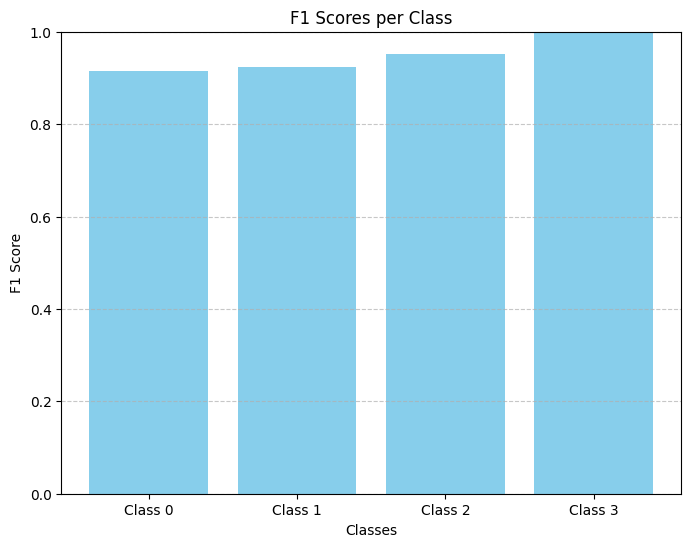

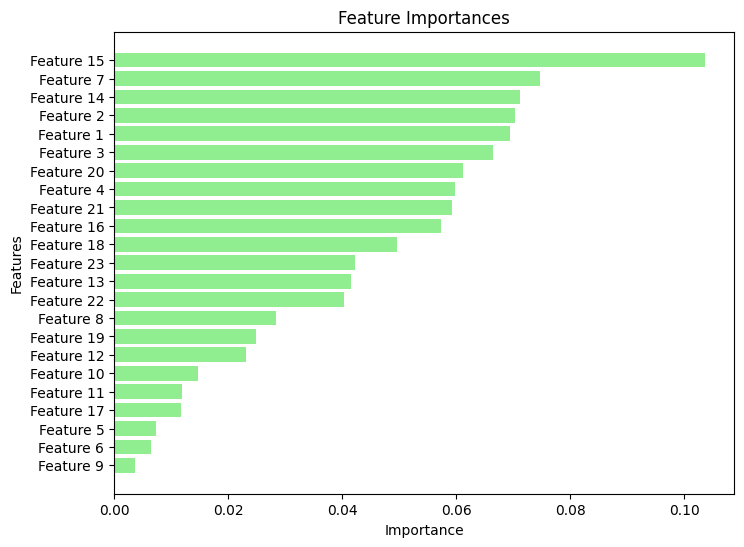

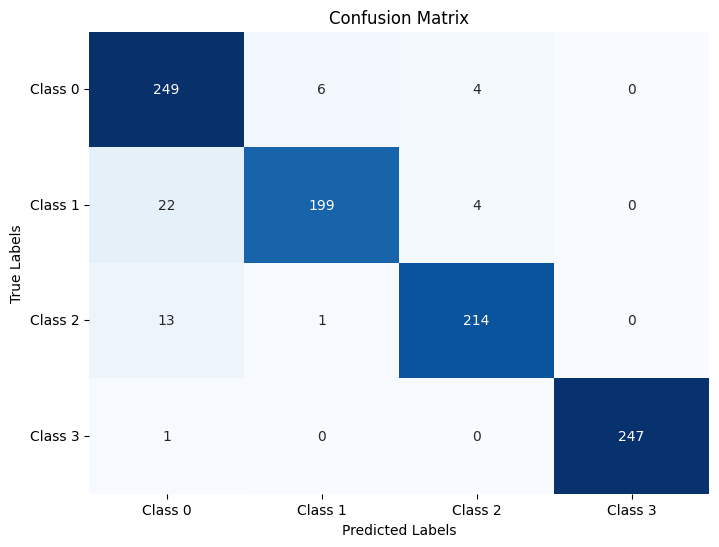

In [48]:
classes = ["Class 0", "Class 1", "Class 2", "Class 3"]
f1_scores = f1_score(y_test_labels, y_pred, average=None)

feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]
feature_importances = best_model_rf.feature_importances_

conf_matrix = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.title("F1 Scores per Class")
plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
sorted_indices = np.argsort(feature_importances)[::-1]
plt.barh(range(len(feature_importances)), np.array(feature_importances)[sorted_indices], align='center', color='lightgreen')
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
plt.show()
